In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ..

/Share/home/shibinbin/projects/emaize


In [337]:
import h5py
import numba
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr, linregress
import pandas as pd

/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/numexpr/cpuinfo.py:42: UserWarning: [Errno 2] No such file or directory
  warnings.warn(str(e), UserWarning, stacklevel=stacklevel)


In [342]:
def standardize_X(X):
    X_mean = X.mean(axis=0)
    X = X - X_mean[np.newaxis, :]
    X_std = np.sqrt(X*X).mean(axis=0)
    X_std[X_std <= 0] = 1
    X /= X_std[np.newaxis, :]
    return X

trait = 'trait2'
with h5py.File('output/random_select/10000', 'r') as f:
    X = standardize_X(f['/0/X'][270:400, :].T)
with h5py.File('data/phenotypes/all', 'r') as f:
    y = f[trait][:]
with h5py.File('output/fastlmm/cv_index.cross', 'r') as f:
    train_index = f['/0/train'][:]
    test_index = f['/0/test'][:]
    train_index = np.random.choice(train_index, size=1000, replace=False)
    test_index = np.random.choice(test_index, size=1000, replace=False)
X_train, y_train = X[train_index], y[train_index]
X_test, y_test = X[test_index], y[test_index]

In [338]:
phenotypes = pd.read_table('emaize_data/phenotype/pheno_emaize.txt')
predictions = pd.read_table('output/predictions/best.txt')
phenotypes['int_id'] = np.arange(phenotypes.shape[0])
phenotypes.index = phenotypes['id']
predictions.index = predictions['id']
predictions['int_id'] = phenotypes.loc[predictions['id'], 'int_id']

In [369]:
predictions1 = pd.read_table('output/predictions/1.txt')
predictions1.index = predictions1['id']
predictions1['int_id'] = phenotypes.loc[predictions1['id'], 'int_id']

In [357]:
with h5py.File('data/parent_table', 'r') as f:
    parent_table = f['data'][:]
s1f_index = np.ravel(parent_table[-5:, :-5])
s1m_index = np.ravel(parent_table[:-5, -5:])
s0_index = np.ravel(parent_table[-5:, -5:])
print s0_index.shape, s1f_index.shape, s1m_index.shape

(25,) (1010,) (125,)


In [147]:
with h5py.File('output/gsm/random_select/100000/1') as f:
    U0 = f['U'][:]
    S0 = f['S'][:]
    U0 = U0[:, S0**2 > 0.5]
    S0 = S0[S0**2 > 0.5]
    U0 /= U0.std(axis=0)[np.newaxis, :]

In [148]:
U0.std(axis=0).shape

(357,)

In [32]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(U0[train_index_all], y[train_index_all])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [35]:
pearsonr(linreg.predict(U0[train_index_all]), y[train_index_all])

(0.95823605682251922, 0.0)

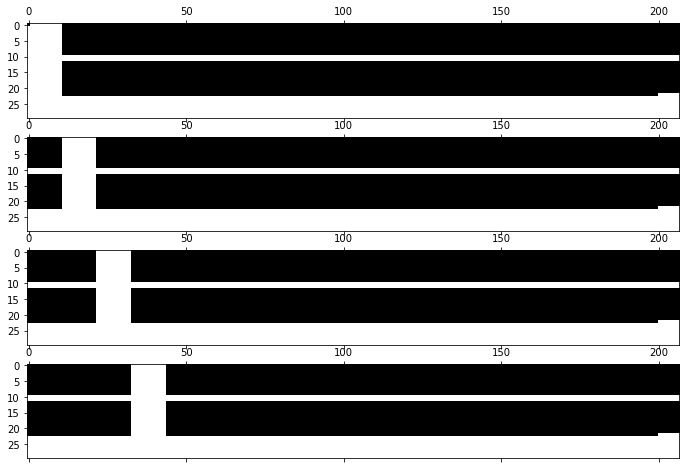

In [228]:
def create_cv_folds(indices_table, mask=None, k1=25, k2=20):
    train_index_list = []
    test_index_list = []
    N1, N2 = indices_table.shape
    size1 = int(np.ceil(float(indices_table.shape[0])/k1))
    size2 = int(np.ceil(float(indices_table.shape[1])/k2))
    for i in range(k1):
        for j in range(k2):
            train_index1 = np.setdiff1d(np.r_[:N1], np.r_[(size1*i):min(size1*(i + 1), N1)])
            train_index2 = np.setdiff1d(np.r_[:N2], np.r_[(size2*j):min(size2*(j + 1), N2)])

            train_index = np.ravel(indices_table[train_index1, :][:, train_index2])
            train_index_list.append(train_index[mask[train_index]])
            test_index = np.setdiff1d(np.ravel(indices_table), train_index)
            test_index_list.append(test_index[mask[test_index]])
    return train_index_list, test_index_list

female_train = np.nonzero(~np.all(np.isnan(np.take(y, parent_table)), axis=0))[0]
male_train = np.nonzero(~np.all(np.isnan(np.take(y, parent_table)), axis=1))[0]
parent_table_train = parent_table[male_train, :][:, female_train]
notnan_mask = ~np.isnan(y)

indices_table = np.zeros(np.prod(parent_table.shape), dtype='int64')
indices_table[~np.isnan(y)] = np.arange((~np.isnan(y)).sum())
indices_table = indices_table.reshape(parent_table.shape)
indices_table_train = indices_table[male_train, :][:, female_train]
train_index_all = np.nonzero(~np.isnan(y))[0]
test_index_all = np.nonzero(np.isnan(y))[0]
train_index_list, test_index_list = create_cv_folds(indices_table, mask=notnan_mask)

fig, ax = plt.subplots(4, 1, figsize=(15, 8))
for i in range(4):
    parent_table_mask = np.zeros(np.prod(parent_table.shape), dtype='bool')
    parent_table_mask[train_index_list[i + 100]] = True
    parent_table_mask = parent_table_mask.reshape(parent_table.shape)
    ax[i].matshow(parent_table_mask, cmap=cm.Greys)

In [8]:
len(test_index_list)

500

In [9]:
from tqdm import tqdm_notebook

In [362]:
def plot_phenotypes(y_true, y_pred, trait):
    pred_matrix = np.full(y.shape[0], np.nan)
    pred_matrix[test_index_all] = np.ravel(y_pred)
    pred_matrix = np.take(pred_matrix, parent_table)

    fig, ax = subplots(2, 1, figsize=(16, 6))
    ax[0].matshow(np.take(normalize_phenotype(np.ravel(y_true)), parent_table), cmap=cm.RdBu)
    ax[0].set_title('Phenotypes of training data (%s)'%trait)

    ax[1].matshow(normalize_phenotype(pred_matrix), cmap=cm.RdBu)
    ax[1].set_title('Prediction on test data (%s)'%trait)

In [366]:
import numba
@numba.jit
def take2d(x, indices1, indices2):
    res = np.zeros((indices1.shape[0], indices2.shape[0]))
    for i in range(indices1.shape[0]):
        for j in range(indices2.shape[0]):
            res[i, j] = x[indices1[i], indices2[j]]
    return res

class FastRidgeCV(object):
    def __init__(self, alphas=None):
        if alphas is not None:
            self.alphas = np.asarray(alphas)
        else:
            self.alphas = alphas

    def fit(self, X, y):
        U, D, V = np.linalg.svd(X, full_matrices=False)
        D2 = D**2
        V = V.T
        if self.alphas is not None:
            if len(self.alphas.shape) > 0 and (self.alphas.shape[0] != X.shape[1]):
                raise ValueError('number of alphas is not equal to the number of columns in X')
            Kinv = (D2/(D2 + self.alphas))[np.newaxis, :]
            self.S = (U*Kinv).dot(U.T)
        else:
            Kinv = 1.0/D2
            self.S = U.dot(U.T)
        self.y_ = self.S.dot(y)
        self.e_ = self.y_ - y
        if self.alphas is not None:
            self.beta_ = (V*(D/(D2 + self.alphas))[np.newaxis, :]).dot(U.T).dot(y)
        else:
            self.beta_ = (V/D[np.newaxis, :]).dot(U.T).dot(y)

    def leave_one_out(self):
        return np.mean((np.ravel(self.e_) / (1.0 - np.diag(self.S))) ** 2)

    def kfold(self, test_indices, return_mean=True, approx=False):
        k = len(test_indices)
        mse_cv = np.zeros(k)
        S_diag = np.diag(self.S)
        err_n = np.zeros(self.S.shape[0])
        err_sum = np.zeros(self.S.shape[0])
        err_ss = np.zeros(self.S.shape[0])
        
        for i, indices, in tqdm_notebook(enumerate(test_indices), total=len(test_indices)):
            if approx:
                mse_cv[i] = np.mean((np.ravel(self.e_[indices]) / (1.0 - S_diag[indices])) ** 2)
            else:
                Si = take2d(self.S, indices, indices)
                Ii = np.identity(Si.shape[0])
                Bi = Si.dot(np.linalg.inv(Ii - Si)) + Ii
                ei_ = self.e_[indices]
                err = Bi.dot(ei_)
                err_n[indices] += 1
                err_sum[indices] += np.ravel(err)9
                err_ss[indices] += np.ravel(err**2)
                mse_cv[i] = np.squeeze(err.T.dot(err)) / indices.shape[0]
        
        self.err_sum = err_sum
        self.err_ss = err_ss
        self.err_n = err_n
        if return_mean:
            return mse_cv.mean()
        else:
            return mse_cv

    def predict(self, X):
        return X.dot(self.beta_)

fast_ridge = FastRidgeCV(alphas=1.0)
fast_ridge.fit(U0[train_index_all], y[train_index_all])
y_pred = fast_ridge.predict(U0[train_index_all])
#mse_cv = fast_ridge.kfold(test_index_list, return_mean=False)
mean_squared_error(y_pred, y[train_index_all])
print np.nanmean(mse_cv)

1.41851241102


iter=0, gamma=0.050000, mse=0.907337, delta_mse=0.907337


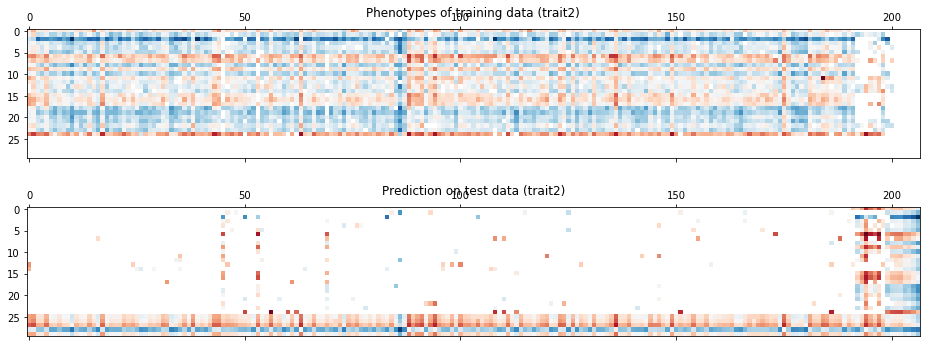

In [387]:
class MixedRidge(object):
    def __init__(self, alphas=None):
        if alphas is not None:
            self.alphas = np.asarray(alphas)
        else:
            self.alphas = alphas
    
    def regress_beta(self, X, y, alphas=None, return_S=False):
        U, D, V = np.linalg.svd(X, full_matrices=False)
        D2 = D**2
        V = V.T
        if alphas is not None:
            if len(alphas.shape) > 0 and (alphas.shape[0] != X.shape[1]):
                raise ValueError('number of alphas is not equal to the number of columns in X')
            Kinv = (D2/(D2 + alphas))[np.newaxis, :]
        else:
            Kinv = 1.0/D2
        if self.alphas is not None:
            beta = (V*(D/(D2 + alphas))[np.newaxis, :]).dot(U.T).dot(y)
        else:
            beta = (V/D[np.newaxis, :]).dot(U.T).dot(y)
        if return_S:
            if self.alphas is not None:
                S = (U*Kinv).dot(U.T)
            else:
                S = U.dot(U.T)
            return beta, S
        else:
            return beta
            
    def fit(self, X1, X2, y, max_iter=100, tol=1e-5, gamma=None):
        # mix factor
        if X1.shape[0] != X2.shape[0]:
            raise ValueError('number of rows in X1 and X2 is not equal')
        N = X1.shape[0]
        if y.shape[0] != N:
            raise ValueError('number of rows in y is not equal to X1 and X2')
        
        p1, p2 = X1.shape[1], X2.shape[1]
        X = np.zeros((N, p1 + p2 + 1))
        X[:, -1] = 1.0
        
        mse = np.mean(y**2)
        delta_mse = mse
        
        i_iter = 0
        '''
        gamma = np.random.uniform(0.0, 1.0)
        while np.abs(delta_mse) > tol:
            X[:, :p1] = X1*(1.0 - gamma)
            X[:, p1:-1] = X2*gamma
            beta = self.regress_beta(X, y, alphas=self.alphas)
            mse_cur = np.mean((y - X.dot(beta))**2)
            delta_mse = mse_cur - mse
            mse = mse_cur
            print 'iter=%d, gamma=%f, mse=%f, delta_mse=%f'%(i_iter, gamma, mse, delta_mse)
            y1 = X1.dot(beta[:p1])
            y2 = X2.dot(beta[p1:-1])
            res = beta[-1]
            y_gamma = np.ravel(y - y1 - res)
            x_gamma = np.ravel(y2 - y1)
            gamma, intercept, _, _, _ = linregress(x_gamma, y_gamma)
            i_iter += 1
            if i_iter > max_iter:
                break'''
                
        '''
        for i_iter, gamma in enumerate(np.linspace(0.0, 1.0, 11, endpoint=True)):
            X[:, :p1] = X1*(1.0 - gamma)
            X[:, p1:-1] = X2*gamma
            beta = self.regress_beta(X, y, alphas=self.alphas)
            mse_cur = np.mean((y - X.dot(beta))**2)
            delta_mse = mse_cur - mse
            mse = mse_cur
            print 'iter=%d, gamma=%f, mse=%f, delta_mse=%f'%(i_iter, gamma, mse, delta_mse)'''
        print 'iter=%d, gamma=%f, mse=%f, delta_mse=%f'%(i_iter, gamma, mse, delta_mse)
        X[:, :p1] = X1*(1.0 - gamma)
        X[:, p1:-1] = X2*gamma
        beta, S = self.regress_beta(X, y, alphas=self.alphas, return_S=True)
        y1 = X1.dot(beta[:p1])
        y2 = X2.dot(beta[p1:-1])
        self.y1_ = y1
        self.y2_ = y2
        
        self.S = S
        self.y_ = self.S.dot(y)
        self.e_ = self.y_ - y
        self.y = y
        
        self.gamma_ = gamma
        self.beta_ = beta
        self.beta1_ = beta[:p1]
        self.beta2_ = beta[p1:-1]
        self.intercept_ = beta[-1]
        
    def predict(self, X1, X2):
        X = np.concatenate([X1*(1.0 - self.gamma_),
                            X2*self.gamma_,
                            np.ones((X1.shape[0], 1), dtype=X1.dtype)], axis=1)
        return X.dot(self.beta_)
    
    def kfold(self, test_indices, return_mean=True, approx=False):
        k = len(test_indices)
        mse_cv = np.zeros(k)
        S_diag = np.diag(self.S)
        err_n = np.zeros(self.S.shape[0])
        err_sum = np.zeros(self.S.shape[0])
        err_ss = np.zeros(self.S.shape[0])
        pcc = np.zeros(len(test_indices))
        
        for i, indices, in tqdm_notebook(enumerate(test_indices), total=len(test_indices)):
            if approx:
                mse_cv[i] = np.mean((np.ravel(self.e_[indices]) / (1.0 - S_diag[indices])) ** 2)
            else:
                Si = take2d(self.S, indices, indices)
                Ii = np.identity(Si.shape[0])
                Bi = Si.dot(np.linalg.inv(Ii - Si)) + Ii
                ei_ = self.e_[indices]
                err = Bi.dot(ei_)
                err_n[indices] += 1
                err_sum[indices] += np.ravel(err)
                err_ss[indices] += np.ravel(err**2)
                pcc[i] = pearsonr(y[indices], y[indices] + err)[0]
                mse_cv[i] = np.squeeze(err.T.dot(err)) / indices.shape[0]
        
        self.err_sum = err_sum
        self.err_ss = err_ss
        self.err_n = err_n
        self.pcc = pcc
        if return_mean:
            return mse_cv.mean()
        else:
            return mse_cv
    
    def leave_one_out(self):
        return np.mean((np.ravel(self.e_) / (1.0 - np.diag(self.S))) ** 2)
    
mixed_ridge = MixedRidge(alphas=2.0)
mixed_ridge.fit(X1=X[train_index_all], X2=U0[train_index_all], y=y[train_index_all], gamma=0.05)
y_pred = mixed_ridge.predict(X1=X[train_index_all], X2=U0[train_index_all])

def normalize_phenotype(x, range_pheno=4.0):
    return (np.clip(x, -range_pheno, range_pheno) + range_pheno)/2.0/range_pheno

y_pred = mixed_ridge.predict(X1=X[test_index_all], X2=U0[test_index_all])
pred_matrix = np.full(y.shape[0], np.nan)
pred_matrix[test_index_all] = np.ravel(y_pred)
pred_matrix = np.take(pred_matrix, parent_table)

fig, ax = subplots(2, 1, figsize=(16, 6))
ax[0].matshow(np.take(normalize_phenotype(np.ravel(y)), parent_table), cmap=cm.RdBu)
ax[0].set_title('Phenotypes of training data (%s)'%trait)

ax[1].matshow(normalize_phenotype(pred_matrix), cmap=cm.RdBu)
ax[1].set_title('Prediction on test data (%s)'%trait)

In [390]:
mixed_ridge.kfold(test_index_list)

/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in double_scalars


nan

0.8810098634039536

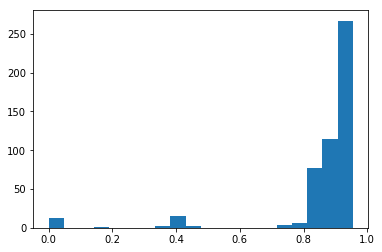

In [394]:
h = hist(nan_to_num(mixed_ridge.pcc), bins=20)
np.nanmean(mixed_ridge.pcc)

PCC(pred, best), all = 0.517835469952
PCC(pred, best), s0 = -0.72454548976
PCC(pred, best), s1m = 0.895910098558
PCC(pred, best), s1f = 0.217670626693


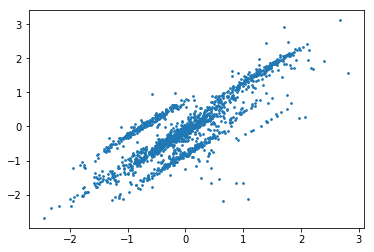

In [388]:
y_pred_full = np.zeros(phenotypes.shape[0])
y_pred_full[test_index_all] = y_pred
best_full = np.zeros(phenotypes.shape[0])
best_full[test_index_all] = predictions1[trait].values

print 'PCC(pred, best), all =', pearsonr(y_pred_full[test_index_all], best_full[test_index_all])[0]
print 'PCC(pred, best), s0 =', pearsonr(y_pred_full[s0_index], best_full[s0_index])[0]
print 'PCC(pred, best), s1m =', pearsonr(y_pred_full[s1m_index], best_full[s1m_index])[0]
print 'PCC(pred, best), s1f =', pearsonr(y_pred_full[s1f_index], best_full[s1f_index])[0]
scatter(y_pred, predictions['trait2'].values, s=3)

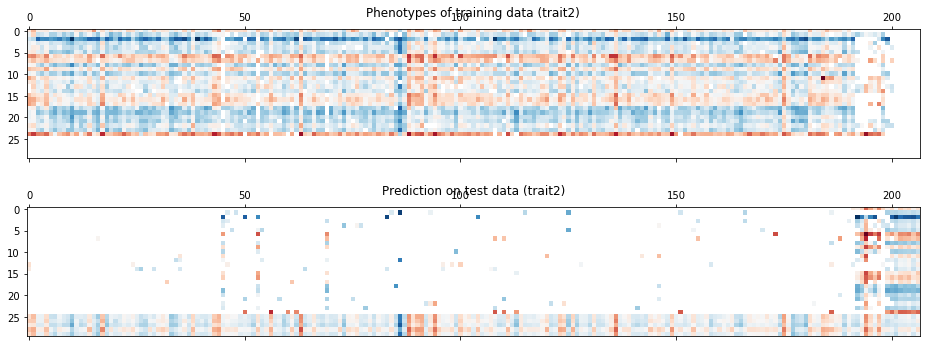

In [376]:
plot_phenotypes(y, predictions1[trait].values, trait)

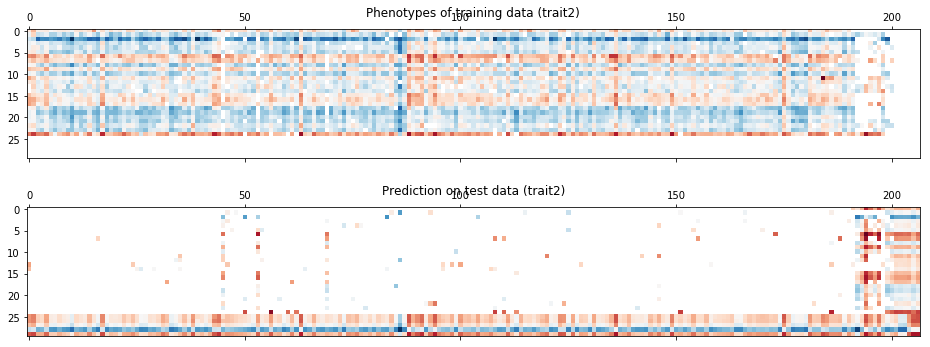

In [377]:
plot_phenotypes(y, predictions[trait].values, trait)

PCC(pred, best), all = 0.827789013137
PCC(pred, best), s0 = 0.186857155753
PCC(pred, best), s1m = 0.889267280294
PCC(pred, best), s1f = 0.830124144623


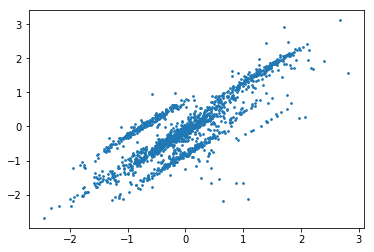

In [389]:
y_pred_full = np.zeros(phenotypes.shape[0])
y_pred_full[test_index_all] = y_pred
best_full = np.zeros(phenotypes.shape[0])
best_full[test_index_all] = predictions[trait].values

print 'PCC(pred, best), all =', pearsonr(y_pred_full[test_index_all], best_full[test_index_all])[0]
print 'PCC(pred, best), s0 =', pearsonr(y_pred_full[s0_index], best_full[s0_index])[0]
print 'PCC(pred, best), s1m =', pearsonr(y_pred_full[s1m_index], best_full[s1m_index])[0]
print 'PCC(pred, best), s1f =', pearsonr(y_pred_full[s1f_index], best_full[s1f_index])[0]
scatter(y_pred, predictions['trait2'].values, s=3)

PCC(y1) = (0.61509927798106623, 0.0)
PCC(y2) = (0.13856704537264175, 8.1577215900913408e-22)


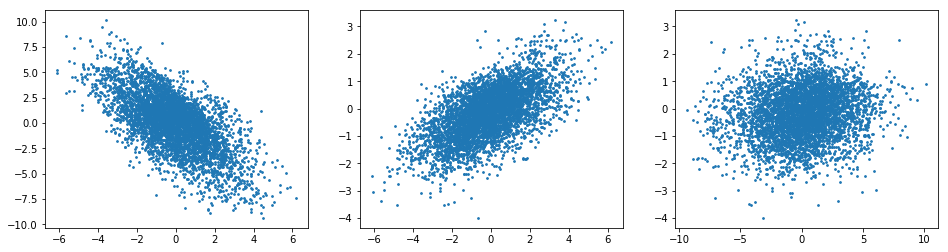

In [280]:
print 'PCC(y1) =', pearsonr(mixed_ridge.y1_, y[train_index_all])
print 'PCC(y2) =', pearsonr(mixed_ridge.y2_, y[train_index_all])
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].scatter(mixed_ridge.y1_, mixed_ridge.y2_, s=3)
axes[1].scatter(mixed_ridge.y1_, y[train_index_all], s=3)
axes[2].scatter(mixed_ridge.y2_, y[train_index_all], s=3)

In [ ]:
mse_cv = mixed_ridge.kfold(test_index_list, return_mean=False)
print np.nanmean(mse_cv)

In [241]:
err_n = np.where(mixed_ridge.err_n == 0, 1, mixed_ridge.err_n)
err_ms = np.mean(mixed_ridge.err_ss/err_n)
print err_n[:10]
print mixed_ridge.err_sum[:10]/err_n[:10]
print mixed_ridge.err_ss[:10]/err_n[:10]
print err_ms
print 'pcc[] =', mixed_ridge.pcc[:10]
print 'pcc_mean =', mixed_ridge.pcc.mean()

AttributeError: 'MixedRidge' object has no attribute 'err_n'

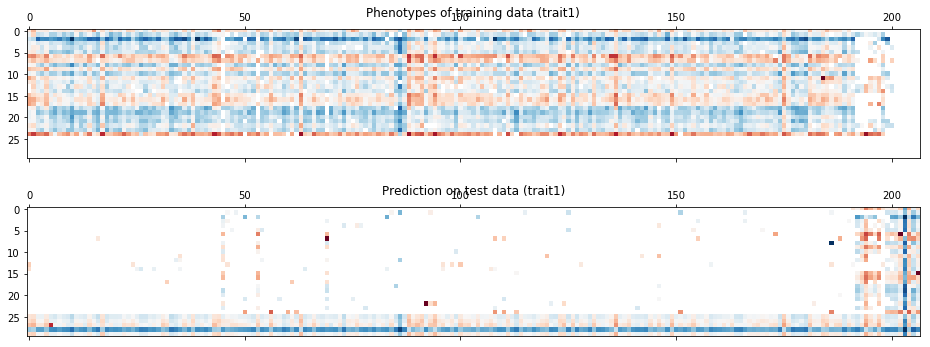

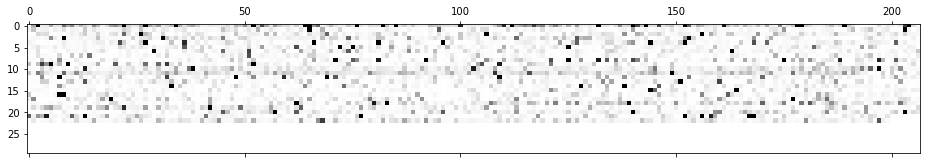

In [173]:
err_sum_table = np.zeros(np.prod(parent_table.shape))
err_sum_table[train_index_all] = mixed_ridge.err_ss/err_n
err_sum_table = err_sum_table.reshape(parent_table.shape)
matshow(np.clip(err_sum_table, 0, 5), cmap=cm.Greys)

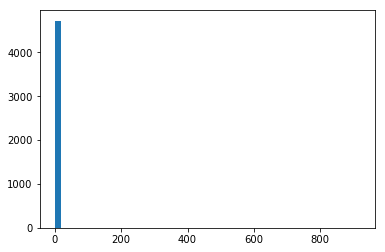

In [165]:
h = hist(mixed_ridge.err_ss/err_n, bins=50)

In [159]:
mixed_ridge.err_sum

array([   0.        ,   48.95680534,  108.86983876, ...,  -71.50309507,
        -22.52104221,   -0.66843706])

In [166]:
mixed_ridge.leave_one_out()

1.058312515003647

In [169]:
print pearsonr(y_pred, y[train_index_all])
print mean_squared_error(y_pred, y[train_index_all])

(0.84344847668517409, 0.0)
0.296073610631


In [128]:
U0, S0, V0 = np.linalg.svd(G0, full_matrices=False)

In [137]:
model = FastRidgeCV(alphas=0.01)
model.fit(X[train_index_all], y[train_index_all])
y_pred = model.predict(X[train_index_all])

In [138]:
model.leave_one_out()

0.092209076779724897

In [122]:
mse_cv = model.kfold(test_index_list, return_mean=False)

/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


In [123]:
np.nanmean(mse_cv)

0.17309529813328076

In [124]:
from scipy.stats import pearsonr
pearsonr(y_pred, y[train_index_all])

(0.95966414360808605, 0.0)

In [134]:
V0[:6210, :]

array([[  3.54088756e-04,   1.92108593e-04,   2.09008009e-04, ...,
         -5.88748197e-04,   1.83748605e-04,   3.75198666e-04],
       [  1.85990993e-05,  -1.48216770e-06,  -1.39548956e-05, ...,
         -6.42864441e-04,   9.30494134e-05,   2.62543745e-05],
       [ -4.81310126e-04,  -3.11837823e-04,  -3.13703291e-04, ...,
          3.60652659e-04,  -2.73188780e-04,  -4.93102241e-04],
       ..., 
       [  3.03628376e-08,  -6.23204571e-04,  -3.27568799e-02, ...,
          8.37655128e-16,  -4.47733747e-03,   1.02305520e-09],
       [ -5.34102851e-09,  -4.10804152e-02,  -1.91262574e-03, ...,
         -9.28881741e-16,  -1.22662364e-02,  -9.06756406e-11],
       [  2.51525578e-09,   1.93566699e-02,  -3.83215100e-02, ...,
         -5.42434341e-16,   1.13263736e-02,  -1.83421802e-11]], dtype=float32)